In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt

In [2]:
mongo = Mongo_connection()
mongo.connect()

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 50 documents.


In [3]:
pID = "002"
trial = 2
document = mongo.find_one({"pID": pID, "trial": trial})

In [5]:
d_data = document["data"]
df_data = pd.DataFrame(d_data)

sr = 3
signal = granger_causation_test.create_signal_from_transitions(df_data, sr)

df_granger = granger_causation_test.granger_causality_test(signal)

print(df_granger[df_granger["pval"] < 0.05])

        roi1     roi2 lag   pval
21       alt   runway   1  0.001
22       alt   runway   2  0.003
23       alt   runway   3  0.002
24       alt   runway   4  0.003
25       alt   runway   5  0.009
26       alt   runway   6  0.012
27       alt   runway   7  0.020
28       alt   runway   8  0.038
50       asi   runway   0  0.002
51       asi   runway   1  0.000
52       asi   runway   2  0.000
53       asi   runway   3  0.000
54       asi   runway   4  0.000
55       asi   runway   5  0.000
56       asi   runway   6  0.000
57       asi   runway   7  0.000
58       asi   runway   8  0.000
59       asi   runway   9  0.000
80   unknown   runway   0  0.009
110   runway  unknown   0  0.013
111   runway  unknown   1  0.020
112   runway  unknown   2  0.037
114   runway  unknown   4  0.043


In [6]:
metadata = {
    "pID": pID,
    "trial": trial,
    "sr": sr
}

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss

def run_adf_kpss_test(signals_from_transitions):
    lroi = []
    lstat = []
    lpval = []
    lnlag = []
    lcritval = []
    ltesttype = []

    for k, v in signals_from_transitions.items():
        signal = v
        adf_result = adfuller(signal)
        lroi.append(k)
        ltesttype.append("adf")
        lstat.append(adf_result[0])
        lpval.append(round(adf_result[1],3))
        lnlag.append(adf_result[2])
        lcritval.append(adf_result[4])

        kpss_result = kpss(signal, nlags="auto")
        lroi.append(k)
        ltesttype.append("kpss")
        lstat.append(kpss_result[0])
        lpval.append(round(kpss_result[1],3))
        lnlag.append(kpss_result[2])
        lcritval.append(kpss_result[3])
    
    df_test = pd.DataFrame({"roi": lroi,
                            "test_type": ltesttype,
                            "stat_val": lstat,
                            "pval": lpval,
                            "nlag": lnlag,
                            "crit_val": lcritval})

    return df_test

In [8]:
df_data = pd.DataFrame(signal)
variables = df_data.columns

In [9]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(df_data)) < 0.8
train = df_data[msk]
test = df_data[~msk]

In [10]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [11]:
model = VAR(df_data) #recall that rawData is w/o difference operation
for i in [1,2,3]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -10.456760931390457
BIC :  -10.276249623255044
FPE :  2.875331656217063e-05
HQIC:  -10.3856600942953 

Lag Order = 2
AIC :  -10.480871303858361
BIC :  -10.155411345212487
FPE :  2.8068831492261833e-05
HQIC:  -10.352665619320366 

Lag Order = 3
AIC :  -10.472478973904163
BIC :  -10.001587840309767
FPE :  2.8306566537148994e-05
HQIC:  -10.286967958313031 



In [12]:
# Lag Order = 10
# FPE :  3.065944644454407e-14

model = VAR(train)
model_fitted = model.fit(10)

c:\users\work\anaconda3\envs\kia\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_data.columns, out):
    print(col, ':', round(val, 2))

alt : 1.97
asi : 2.04
unknown : 2.0
runway : 2.0


In [14]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(df_data['runway'], df_data['asi'])
print(result)

(-6.921435378106763, 1.3184436445964957e-08, array([-3.9205653 , -3.34953269, -3.05374355]))


In [15]:
lag_order = model_fitted.k_ar

In [16]:
test = 'ssr_chi2test'
maxlag = lag_order
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [17]:
grangers_causation_matrix(df_data, variables)

,alt_x,asi_x,unknown_x,runway_x
alt_y,1.0000,0.2301,0.1847,0.0011
asi_y,0.4204,1.0000,0.1129,0.0000
unknown_y,0.2917,0.4827,1.0000,0.0082
runway_y,0.2144,0.1555,0.0121,1.0000


In [18]:
def draw_signals(signal, rois, metadata):
    """
    signal: return from granger_causation_test.create_signal_from_transitions
    rois: 2 rois that you want to draw together."""
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(signal[rois[0]], label=rois[0])
    ax.plot(signal[rois[1]], label=rois[1])
    ax.set_xlabel(f"time (sampling rate = {metadata['sr']} Hz)")
    ax.legend()
    plt.title("gaze signal")

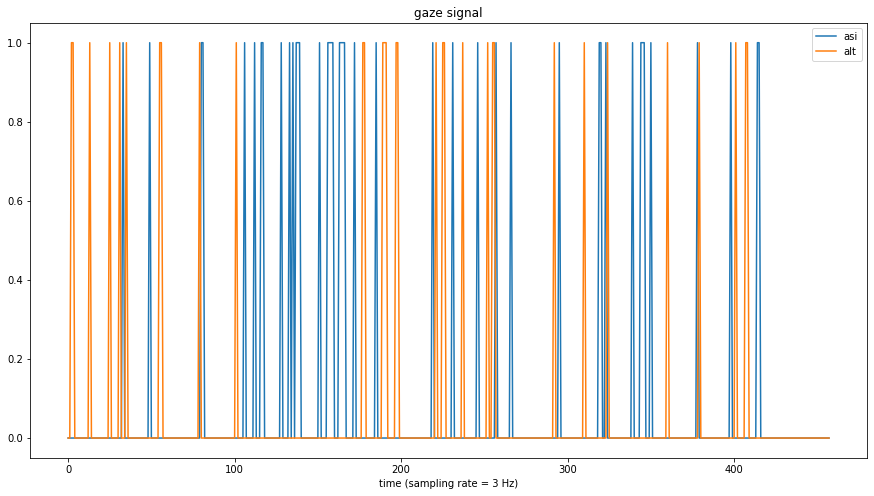

In [20]:
draw_signals(signal, ["asi", "alt"], metadata)